In [ ]:
from pathlib import Path
import os, sys
import geopandas as gpd
import pandas as pd
import math
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from drone_detector.utils import *
from drone_detector.processing.tiling import *

import warnings
warnings.filterwarnings("ignore")
sys.path.append('..')
from src.tree_functions import *

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
# visualization functions

from shapely.geometry import LineString, box, Point, Polygon
from shapely.geometry.polygon import orient
from shapely.ops import nearest_points

def get_three_point_diam_lines(geom):
    d = get_len(geom)
    mrr = geom.minimum_rotated_rectangle
    mrr = orient(mrr)
    mrr_x, mrr_y = mrr.exterior.coords.xy
    a_ix = list(mrr_y).index(min(mrr_y))
    b_ix = a_ix + 1 if a_ix < 3 else 0
    c_ix = b_ix + 1 if b_ix < 3 else 0
    d_ix = c_ix + 1 if c_ix < 3 else 0 
    ab = LineString([Point(mrr_x[a_ix], mrr_y[a_ix]), Point(mrr_x[b_ix], mrr_y[b_ix])])
    ad = LineString([Point(mrr_x[a_ix], mrr_y[a_ix]), Point(mrr_x[d_ix], mrr_y[d_ix])])
    if ab.length > ad.length:
        maxline = ab
        max_ort = LineString([Point(mrr_x[d_ix], mrr_y[d_ix]), Point(mrr_x[c_ix], mrr_y[c_ix])])
    else:
        maxline = ad
        max_ort = LineString([Point(mrr_x[b_ix], mrr_y[b_ix]), Point(mrr_x[c_ix], mrr_y[c_ix])]) 
    bot_a, bot_b = maxline.boundary
    top_a, top_b = max_ort.boundary
    if top_a.y == top_b.y: # horizontal
        line_10 = LineString([Point(min(top_a.x, top_b.x) + 0.10*d, top_a.y), 
                              Point(min(bot_a.x, bot_b.x) + 0.10*d, bot_a.y)])
        line_50 = LineString([Point(min(top_a.x, top_b.x) + 0.5*d, top_a.y), 
                              Point(min(bot_a.x, bot_b.x) + 0.5*d, bot_a.y)])
        line_90 = LineString([Point(max(top_a.x, top_b.x) - 0.10*d, top_b.y),
                              Point(max(bot_a.x, bot_b.x) - 0.10*d, bot_b.y)])
    elif top_a.x == top_b.x: # vertical
        line_10 = LineString([Point(top_a.x, min(top_a.y,  top_b.y) + 0.10*d), 
                              Point(bot_a.x, min(bot_a.y,  bot_b.y) + 0.10*d)])
        line_50 = LineString([Point(top_a.x, min(top_a.y,  top_b.y) + 0.5*d), 
                              Point(bot_a.x, min(bot_a.y,  bot_b.y) + 0.5*d)])
        line_90 = LineString([Point(top_b.x, max(top_a.y,  top_b.y) - 0.10*d), 
                              Point(bot_b.x, max(bot_a.y,  bot_b.y) - 0.10*d)])
    else: # we do geometry, solve <x,y> = <x_1,y_1> + t<1,m>
        k = (bot_b.y - bot_a.y) / (bot_b.x - bot_a.x)
        mul = 1 if k > 0 else -1
        top_x_10 = top_a.x + mul * np.sqrt(((0.10*d)**2)/(1+k**2))
        top_x_50 = top_a.x + mul * np.sqrt(((0.5*d)**2)/(1+k**2))
        top_x_90 = top_a.x + mul * np.sqrt(((0.90*d)**2)/(1+k**2))
        top_y_10 = top_a.y + np.sqrt(((0.10*d*k)**2)/(1+k**2))
        top_y_50 = top_a.y + np.sqrt(((0.5*d*k)**2)/(1+k**2))
        top_y_90 = top_a.y + np.sqrt(((0.90*d*k)**2)/(1+k**2))
        bot_x_10 = bot_a.x + mul * np.sqrt(((0.10*d)**2)/(1+k**2))
        bot_x_50 = bot_a.x + mul * np.sqrt(((0.5*d)**2)/(1+k**2))
        bot_x_90 = bot_a.x + mul * np.sqrt(((0.90*d)**2)/(1+k**2))
        bot_y_10 = bot_a.y + np.sqrt(((0.10*d*k)**2)/(1+k**2))
        bot_y_50 = bot_a.y + np.sqrt(((0.5*d*k)**2)/(1+k**2))
        bot_y_90 = bot_a.y + np.sqrt(((0.90*d*k)**2)/(1+k**2))
        line_10 = LineString([Point(top_x_10, top_y_10), Point(bot_x_10, bot_y_10)])
        line_50 = LineString([Point(top_x_50, top_y_50), Point(bot_x_50, bot_y_50)])
        line_90 = LineString([Point(top_x_90, top_y_90), Point(bot_x_90, bot_y_90)])
    return line_10, line_50, line_90

def get_iline(geom):
    p1, p2 = nearest_points(geom.minimum_rotated_rectangle.exterior, geom.representative_point())
    minx, miny, maxx, maxy = geom.bounds
    line = LineString([p1,p2])
    bbox = box(*geom.bounds)
    a,b = line.boundary
    if a.x == b.x:
        extended_line = LineString([(a.x, miny), (a.x, maxy)])
    elif a.y == b.y:
        extended_line = LineString([(minx, a.y), (maxx, a.y)])
    else:
        k = (b.y - a.y) / (b.x - a.x)
        m = a.y - k * a.x
        y0 = k * minx + m
        y1 = k * maxx + m
        x0 = (miny - m) / k
        x1 = (maxy - m) / k
        points_on_boundary_lines = [Point(minx, y0), Point(maxx, y1), 
                                    Point(x0, miny), Point(x1, maxy)]
        points_sorted_by_distance = sorted(points_on_boundary_lines, key=bbox.distance)
        extended_line = LineString(points_sorted_by_distance[:2])
    return extended_line.intersection(geom)

# Materials and methods

## Study areas

The first study area is located in the eastern side of Hiidenportti National Park, Sotkamo, Eastern-Finland, and the field data contains areas both inside and outside the conserved areas (Hiidenportti National Park in the west and Teerisuo - Lososuo area in the east). The most common trees in Hiidenportti area are Scots pine and Norway spruce, with different deciduous trees (e.g. Silver birch, Downy birch and European aspen). The UAV data from this study area consist of nine partially overlapping RGB orthoimages which cover approximately 10 km² area, with spatial resolution ranging between 3.9cm and 4.4cm. These scenes cover both conserved and managed forests, as well as some logging openings. The UAV data were collected on 16. and 17.7.2019 using DJI Phantom 4 RTK UAV equipped with 20 megapixel CMOS sensor. 

Our other study area is located in Sudenpesänkangas, Evo, Southern-Finland. The data was acquired on 11.7.2018, using eBee Plus RTK fixed-wing platform, equipped with a 20 megapixel global shutter S.O.D.A camera with a field of view of 64$^{\circ}$. The UAV data from Evo consist of a single RGB orthomosaic which has a spatial resolution of 4.9cm. The area covers both managed and conserved areas, and the canopy is mostly dominated by Scots pine and Norway spruce, with a mixture of the two birch species. Other species (e.g. aspen and larch) are rather scarce in dominant canopy layer. Data from Evo was used for testing the methods in different geographical location

In addition to UAV data, we also have high-resolution LiDAR data from both of our study areas. The point density for Hiidenportti LiDAR data was approximately 15 points/m$^2$, and 11 points/m$^2$ for Evo LiDAR data. These LiDAR data from Hiidenportti were the same as used in [Heinaro et al (2021)](https://www.sciencedirect.com/science/article/pii/S0378112721003133), while the LiDAR data from Evo were used in both [Viinikka et al (2020](https://www.mdpi.com/2072-4292/12/16/2610) and [Mäyrä et al (2021)](https://www.sciencedirect.com/science/article/pii/S0034425721000407). We used these data to create canopy height models (CHMs) with 0.5m spatial resoution for both study areas, which were then used to compute the canopy densities for the field plots.

## Virtual deadwood data

Having accurate and good quality ground reference data is not only important for training the models, but also for evaluating the obtained results. Even though we had extensive field data from both of our study areas, using only these data would not provide enough training data for our methods. For both of our study areas, we constructed rectangular virtual plots (*scenes*) in such way that all usable field plots were covered. Because the sizes of the UAV mosaics were different between the study areas, these plots were constructed slightly differently. For Hiidenportti dataset, we constructed 33 rectangular scenes in such way that all usable field plots were covered and each plot had at least 45 meter distance to the border of the scene. As the total area of Sudenpesänkangas UAV-mosaic is larger than Hiidenportti, we constructed the scenes for Evo area as 100x100 meter non-overlapping squares in such way that each virtual plot contained only one circular field plot.

We manually annotated all visible deadwood from the scenes to use our reference data. Both deadwood types were annotated as a separate classes. The standing deadwood instances were annotated so that the full canopy were inside the polygon, but for fallen deadwood we annotated the trunks and left the branches and twigs unannotated. We annotated even the shortest deadwood instances visible, as it was possible that in reality they belonged of a larger trunk, but were partially obscured by canopy.

### Hiidenportti dataset

Out of the 178 circular field plots with 9m radius present in the Hiidenportti area, our UAV data covered 75 in such way that the image quality was sufficient for our study. Out of these 75, we omitted four plots as they had been cut down between the time of field work and UAV flights, bringing the total number of field plots to 71. 23 of these field plots contained accurately measured and located deadwood data, collected by [Heinaro et al (2021)](https://www.sciencedirect.com/science/article/pii/S0378112721003133). In Evo area, the UAV data covered 79 circular field plots with 9 meter radius, from which 71 had suitable image quality for our use cases.

In [ ]:
full_data = gpd.read_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')
conservation_areas = gpd.read_file('../data/common/LsAlueValtio.shp')
cons_hp = conservation_areas[conservation_areas.geometry.intersects(box(*full_data.total_bounds))]

full_data['conservation'] = full_data.progress_apply(lambda row: 1 if row.geometry.intersects(cons_hp.geometry.unary_union)
                                                                 else 0, axis=1)
full_data.to_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')

  0%|          | 0/8479 [00:00<?, ?it/s]

In total, the final deadwood data contained 7396 annotated fallen deadwood and 1083 standing deadwood instances. The total numbers of deadwood instances present in a single virtual plot varied between 47 and 1051, the number of fallen deadwood between 31 and 990, and for the number of standing deadwood between 1 and 159. Relatively, standing deadwood was much more common in conserved areas than in managed forests, as 59% (639 instances) of standing deadwood were located in conservation areas, compared to 30.6% (2260 instances) of fallen deadwood. 

In [ ]:
pd.crosstab(full_data.conservation, full_data.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,5909,683,6592
1,1487,400,1887
All,7396,1083,8479


In addition to the total number of deadwood instances, these data tells us also the total area covered in m² as well as pixels for each deadwood type, both for the polygons and their bounding boxes. Based on the annotated polygons, we estimated the trunk length of the fallen deadwood and the maximum canopy diameter of the standing deadwood to be the longer side of the minimum rotated rectangle for the corresponding polygon. Because the spatial resolution of our data is around 4cm, we did not estimate fallen deadwood diameter or volume, as even an error of one pixel effects these calculations too much. 

Overall, the total area covered by fallen deadwood was 3459.81m² and 3565.37m² by standing deadwood. The mean area covered by a single fallen deadwood polygon was around 0.47m² and 3.29m² for standing deadwood. 

In [ ]:
full_data['area'] = full_data.geometry.area
full_data['pixel_area'] = full_data.area / 0.04**2
full_data_dis = full_data.dissolve(by='layer')
full_data_dis.area

layer
groundwood     3459.805448
uprightwood    3565.369704
dtype: float64

In [ ]:
pd.pivot_table(full_data, index=['layer'], values='area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,area,area,area,area
layer,,,,
groundwood,0.024711,5.789380,0.469012,0.348866
uprightwood,0.103820,24.334151,3.292461,2.416391
All,0.024711,24.334151,0.829644,0.395097


<seaborn.axisgrid.FacetGrid>

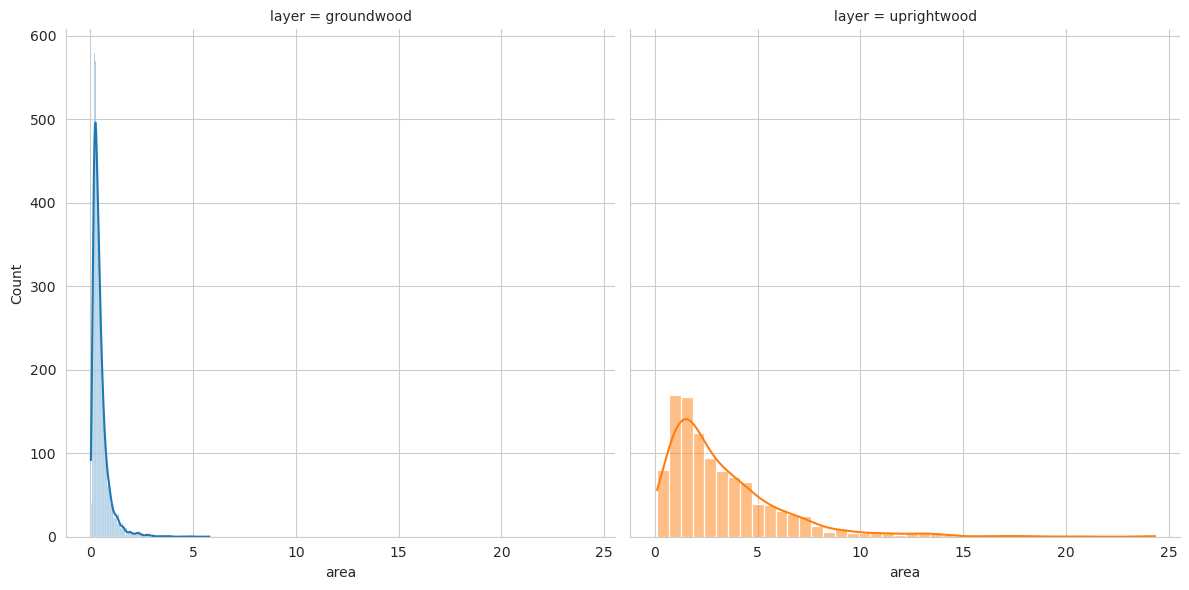

In [ ]:
#| echo: false
g = sns.FacetGrid(full_data, col='layer', height=6, hue='layer')
g.map(sns.histplot, 'area', kde=True, stat='count')

Based on the annotated polygons, we also estimated the trunk length of the fallen deadwood and the maximum canopy diameter of the standing deadwood to be the longest side of the minimum rotated rectangle for the corresponding polygon. For diameter and volume estimation for the fallen deadwood, we constructed three lines that are perpendicular with the minimum rotated rectangle of the polygon that intersect in the polygon at the 10%, 50% and 90% of the length. This process is visualized below. Based on these lines, we used the mean length of these intersecting lines to estimate the polygon diameter. For the volume estimation, we assumed that the fallen deadwood polygons are constructed from two truncated right circular cones and used the following equations to estimate the volume:

$$
    V_{1} = \frac{\pi h(r_{10}^2 + r_{10}r_{50} + r_{50}^2)}{3} \\
    V_{2} = \frac{\pi h(r_{90}^2 + r_{90}r_{50} + r_{50}^2)}{3} \\
    V = V_1 + V_2
$$

where r$_{x}$ are the radii at the length percentile of x, and h is half the estimated polygon length.

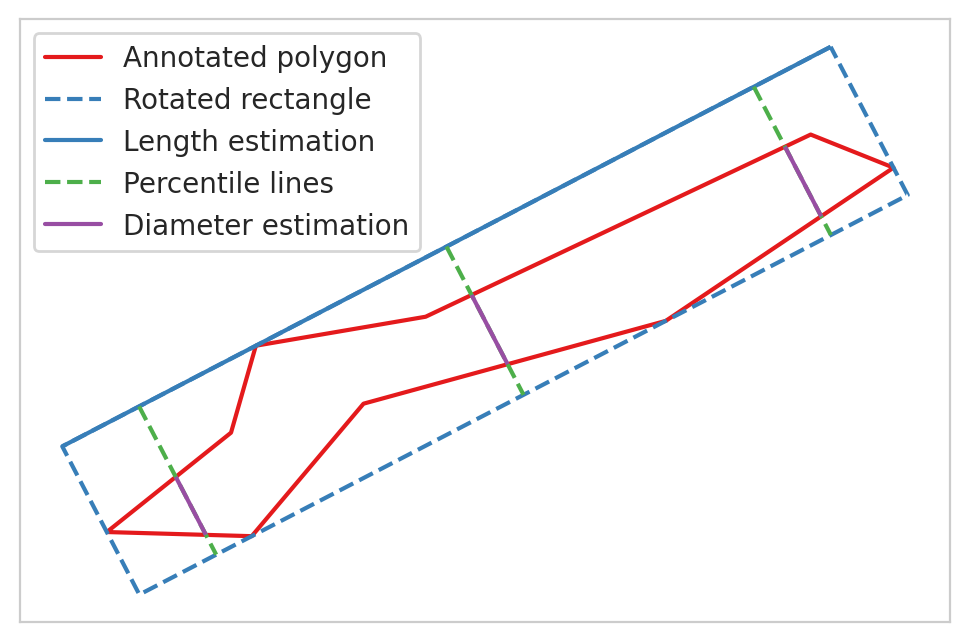

In [ ]:
#| echo: false

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

ix = 95
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=200)
full_data[full_data.layer == 'groundwood'].iloc[ix:ix+1].exterior.plot(ax=ax, color="#e41a1c")
temp = full_data[full_data.layer == 'groundwood'].iloc[ix:ix+1].copy()
geom = temp.iloc[0].geometry
temp['geometry'] = temp.apply(lambda row: row.geometry.minimum_rotated_rectangle, axis=1)
temp.exterior.plot(ax=ax, color='#377eb8', linestyle='--')
temp['geometry'] = temp.apply(lambda row: LineString([(row.geometry.exterior.xy[0][0], row.geometry.exterior.xy[1][0]),
                                                     (row.geometry.exterior.xy[0][1], row.geometry.exterior.xy[1][1])]),
                              axis=1)
l = temp.plot(ax=ax, color='#377eb8')
temp2 = full_data[full_data.layer == 'groundwood'].iloc[ix:ix+1].copy()
lines = get_three_point_diam_lines(temp2.iloc[0].geometry)
for l in lines:
    temp2['geometry'] = l
    temp2.plot(ax=ax, edgecolor='#4daf4a', linestyle='--')
for l in lines:
    temp2['geometry'] = l.intersection(geom)
    temp2.plot(ax=ax, edgecolor='#984ea3')
    
ax.set_xticks([])
ax.set_yticks([])
ax.legend([mlines.Line2D([0],[0], color="#e41a1c"), 
           mlines.Line2D([0],[0], color="#377eb8", linestyle='--'),
           mlines.Line2D([0],[0], color="#377eb8"),
           mlines.Line2D([0],[0], color='#4daf4a', linestyle='--'),
           mlines.Line2D([0],[0], color='#984ea3')],
          ['Annotated polygon', 
           'Rotated rectangle',
           'Length estimation',
           'Percentile lines',
           'Diameter estimation'], loc=2)
plt.savefig('../data/figures/dbh_method.jpeg', bbox_inches='tight', dpi=300)

The average fallen deadwood trunk length was around 2.48 meters, with the shortest annotated tree being 0.21m and longest 15.38m. On average, both deadwood types were larger in the conservation areas compared to the managed forests. It is worth mentioning that 1655 of the annotated fallen deadwood were shorter than 1.3m (the minimum length for the tree to be measured in the Finnish National Forest Inventory), but due to the possibility of them being partially obscured by the canopy, they were included in the deadwood data. 

In [ ]:
full_data['tree_length'] = full_data.apply(lambda row: get_len(row.geometry), axis=1)
len(full_data[(full_data.layer == 'groundwood') & (full_data.tree_length < 1.3)])

1655

Statistics for estimated tree length and canopy diameter.

In [ ]:
pd.pivot_table(full_data, index=['layer'], 
               values=['tree_length'], aggfunc=['min', 'max', 'mean', 'median', 'count'], margins=True)

,min,max,mean,median,count
,tree_length,tree_length,tree_length,tree_length,tree_length
layer,,,,,
groundwood,0.206041,15.383351,2.404708,2.002028,7396
uprightwood,0.385542,8.313442,2.323786,2.154042,1083
All,0.206041,15.383351,2.394372,2.024371,8479


In [ ]:
pd.pivot_table(full_data, index=['conservation', 'layer'], 
               values=['tree_length'], aggfunc=['min', 'max', 'mean', 'median', 'count'], margins=True)

min         max        mean      median  \
                         tree_length tree_length tree_length tree_length   
conservation layer                                                         
0            groundwood     0.206041   15.383351    2.284923    1.915742   
             uprightwood    0.385542    6.977358    2.248640    2.075352   
1            groundwood     0.346741   12.954119    2.880703    2.388131   
             uprightwood    0.633733    8.313442    2.452099    2.294426   
All                         0.206041   15.383351    2.394372    2.024371   

                               count  
                         tree_length  
conservation layer                    
0            groundwood         5909  
             uprightwood         683  
1            groundwood         1487  
             uprightwood         400  
All                             8479

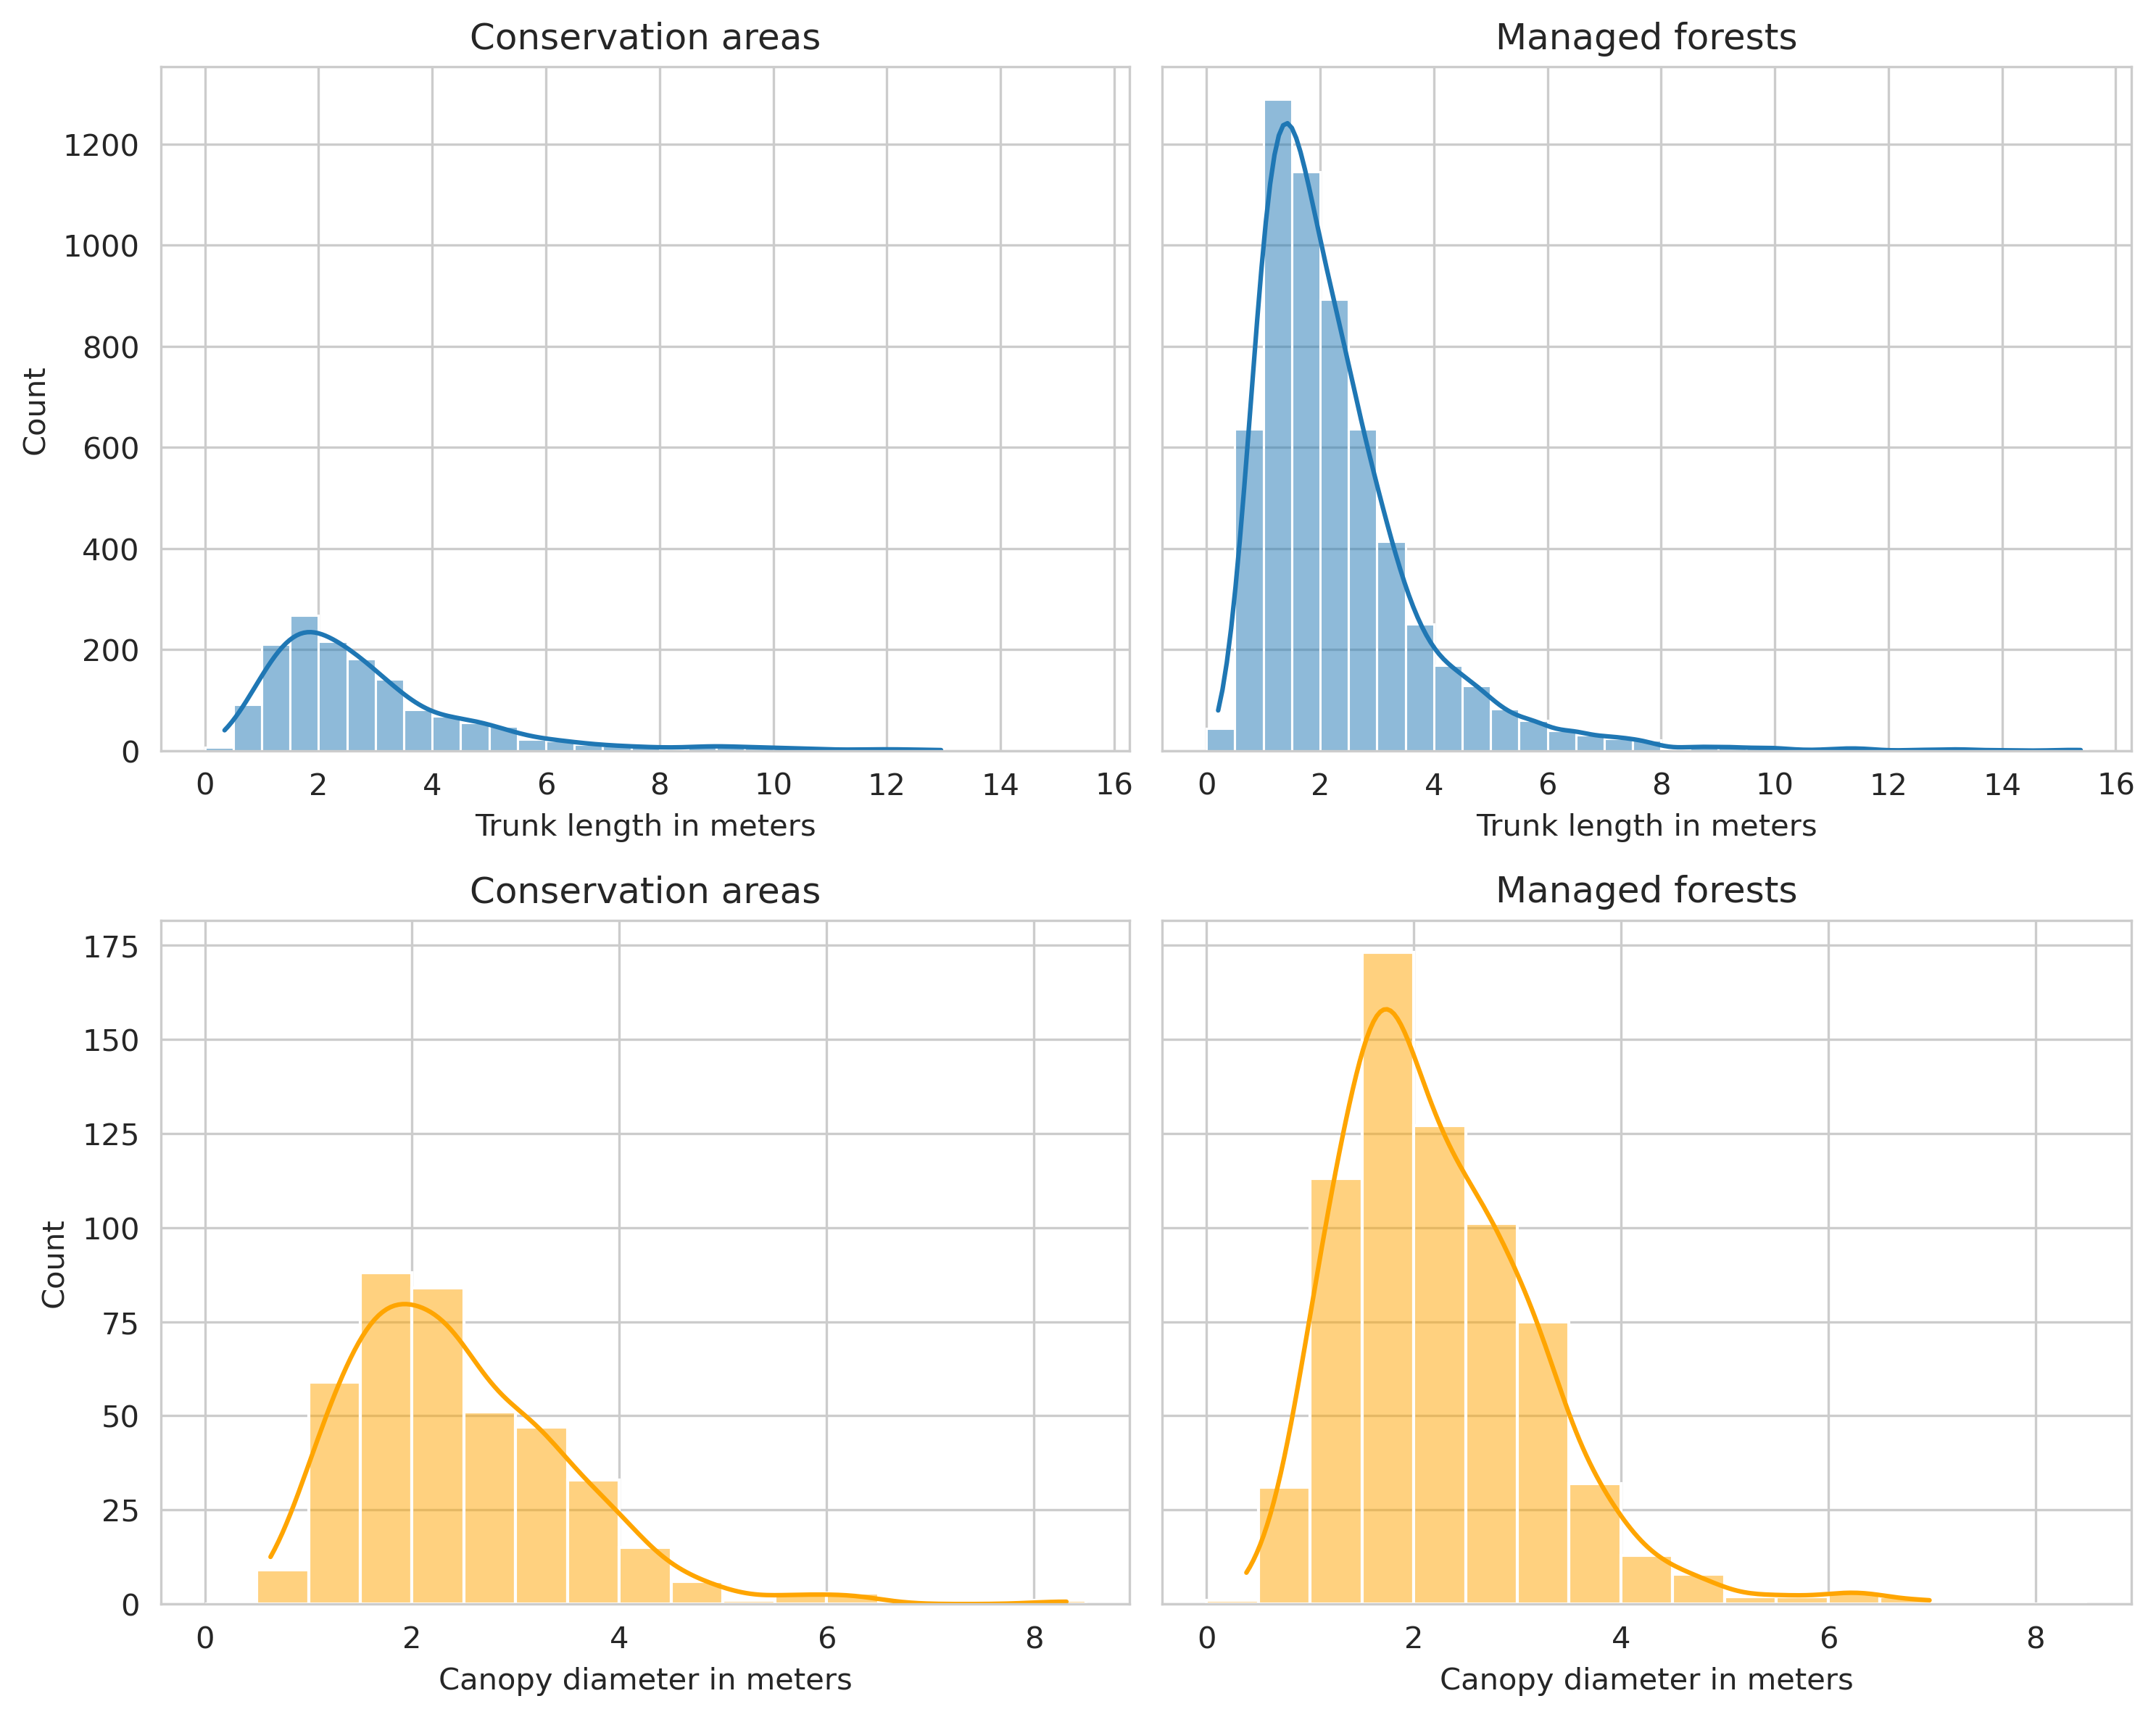

In [ ]:
#| echo: false
fig, ax = plt.subplots(2,2, figsize=(10,8), dpi=300, sharey='row', sharex='row')

sns.histplot(full_data[(full_data.layer=='groundwood') & (full_data.conservation == 1)], 
             x='tree_length', kde=True, stat='count', ax=ax[0,0], binwidth=0.5, 
             binrange=(0,full_data[(full_data.layer=='groundwood')].tree_length.max()))
ax[0,0].set_title('Conservation areas')
ax[0,0].set_xlabel('Trunk length in meters')
sns.histplot(full_data[(full_data.layer=='groundwood') & (full_data.conservation == 0)], 
             x='tree_length', kde=True, stat='count', ax=ax[0,1], binwidth=0.5, 
             binrange=(0,full_data[(full_data.layer=='groundwood')].tree_length.max()))
ax[0,1].set_title('Managed forests')
ax[0,1].set_xlabel('Trunk length in meters')


sns.histplot(full_data[(full_data.layer=='uprightwood') & (full_data.conservation == 1)], 
             x='tree_length', kde=True, stat='count', ax=ax[1,0], color='orange', binwidth=0.5, 
             binrange=(0,full_data[(full_data.layer=='uprightwood')].tree_length.max()))
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Canopy diameter in meters')
sns.histplot(full_data[(full_data.layer=='uprightwood') & (full_data.conservation == 0)], 
             x='tree_length', kde=True, stat='count', ax=ax[1,1], color='orange', binwidth=0.5, 
             binrange=(0,full_data[(full_data.layer=='uprightwood')].tree_length.max()))
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Canopy diameter in meters')
plt.tight_layout()
plt.savefig('../data/figures/hiidenportti_lendist.jpeg', dpi=300, bbox_inches='tight')

Statistics for estimated diameter for groundwood.

In [ ]:
full_data['diam'] = full_data.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
pd.pivot_table(full_data[full_data.layer=='groundwood'], index=['conservation'], 
               values=['diam'], aggfunc=['min', 'max', 'mean', 'median', 'count'], margins=True)

,min,max,mean,median,count
,diam,diam,diam,diam,diam
conservation,,,,,
0,55.336382,626.065954,180.397765,172.583156,5909
1,68.693180,677.660650,208.541880,190.436852,1487
All,55.336382,677.660650,186.056270,175.094096,7396


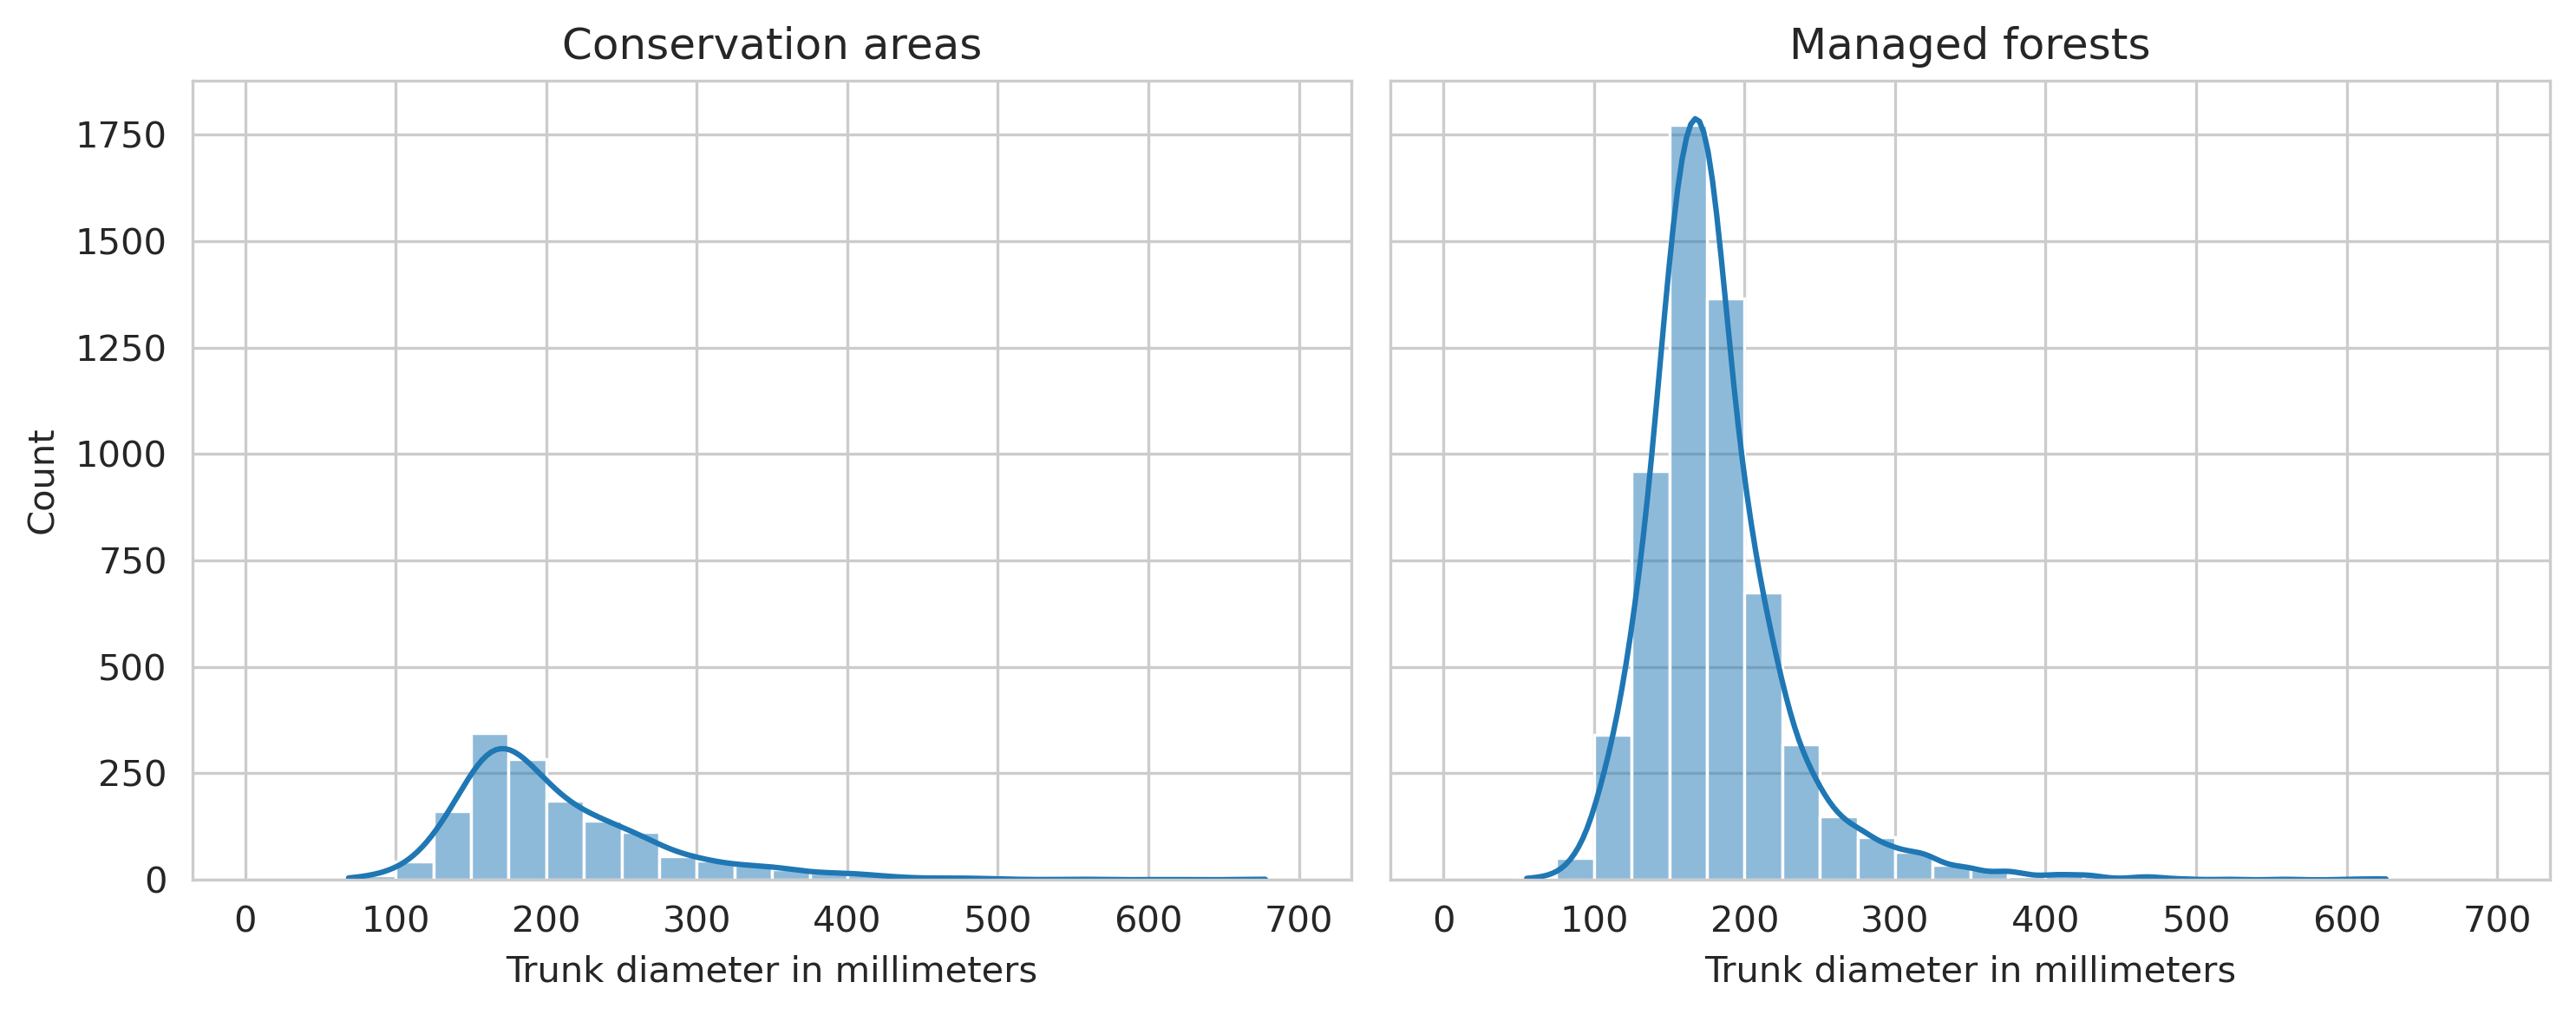

In [ ]:
#| echo: false

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300, sharey=True, sharex=True)
sns.histplot(full_data[(full_data.layer=='groundwood') & (full_data.conservation == 1)], 
             x='diam', kde=True, stat='count', ax=ax[0], binwidth=25, 
             binrange=(0,full_data[(full_data.layer=='groundwood')].diam.max()))
ax[0].set_title('Conservation areas')
ax[0].set_xlabel('Trunk diameter in millimeters')
sns.histplot(full_data[(full_data.layer=='groundwood') & (full_data.conservation == 0)], 
             x='diam', kde=True, stat='count', ax=ax[1], binwidth=25, 
             binrange=(0,full_data[(full_data.layer=='groundwood')].diam.max()))
ax[1].set_title('Managed forests')
ax[1].set_xlabel('Trunk diameter in millimeters')
plt.tight_layout()
plt.savefig('../data/figures/hiidenportti_diamdist.jpeg', dpi=300, bbox_inches='tight')

Look at the largest polygons.


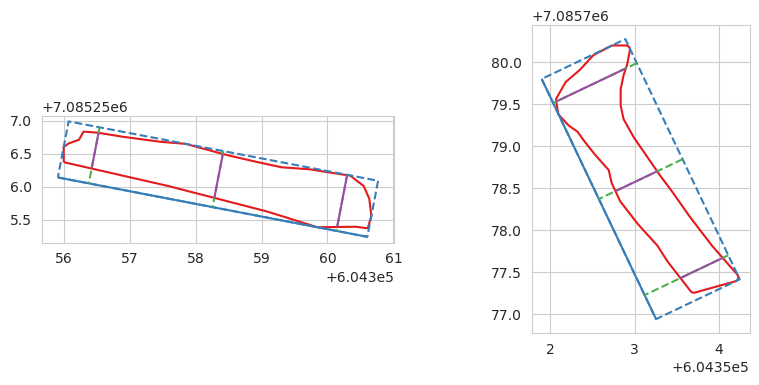

In [ ]:
# echo: false

fig, axs = plt.subplots(1,2, figsize=(10,4))
for ix, ax in enumerate(axs.flatten()):
    full_data[(full_data.layer == 'groundwood')&(full_data.diam>650)].iloc[ix:ix+1].exterior.plot(ax=ax, color="#e41a1c")
    temp = full_data[(full_data.layer == 'groundwood')&(full_data.diam>650)].iloc[ix:ix+1].copy()
    geom = temp.iloc[0].geometry
    temp['geometry'] = temp.apply(lambda row: row.geometry.minimum_rotated_rectangle, axis=1)
    temp.exterior.plot(ax=ax, color='#377eb8', linestyle='--')
    temp['geometry'] = temp.apply(lambda row: LineString([(row.geometry.exterior.xy[0][0], row.geometry.exterior.xy[1][0]),
                                                         (row.geometry.exterior.xy[0][1], row.geometry.exterior.xy[1][1])]),
                                  axis=1)
    temp.plot(ax=ax, color='#377eb8')
    temp2 = full_data[(full_data.layer == 'groundwood')&(full_data.diam>650)].iloc[ix:ix+1].copy()
    lines = get_three_point_diam_lines(temp2.iloc[0].geometry)
    for l in lines:
        temp2['geometry'] = l
        temp2.plot(ax=ax, edgecolor='#4daf4a', linestyle='--')
    for l in lines:
        temp2['geometry'] = l.intersection(geom)
        temp2.plot(ax=ax, edgecolor='#984ea3')
plt.show()

Estimations for volume of fallen deadwood.

In [ ]:
full_data['v'] = full_data.geometry.apply(cut_cone_volume)

pd.pivot_table(full_data[full_data.layer=='groundwood'], index=['conservation'], 
               values=['v'], aggfunc=['min', 'max', 'mean', 'median', 'count', 'sum'], margins=True)

,min,max,mean,median,count,sum
,v,v,v,v,v,v
conservation,,,,,,
0,0.001237,2.399251,0.072439,0.046403,5909,428.041718
1,0.002850,2.130253,0.128083,0.070668,1487,190.459568
All,0.001237,2.399251,0.083626,0.050058,7396,618.501287


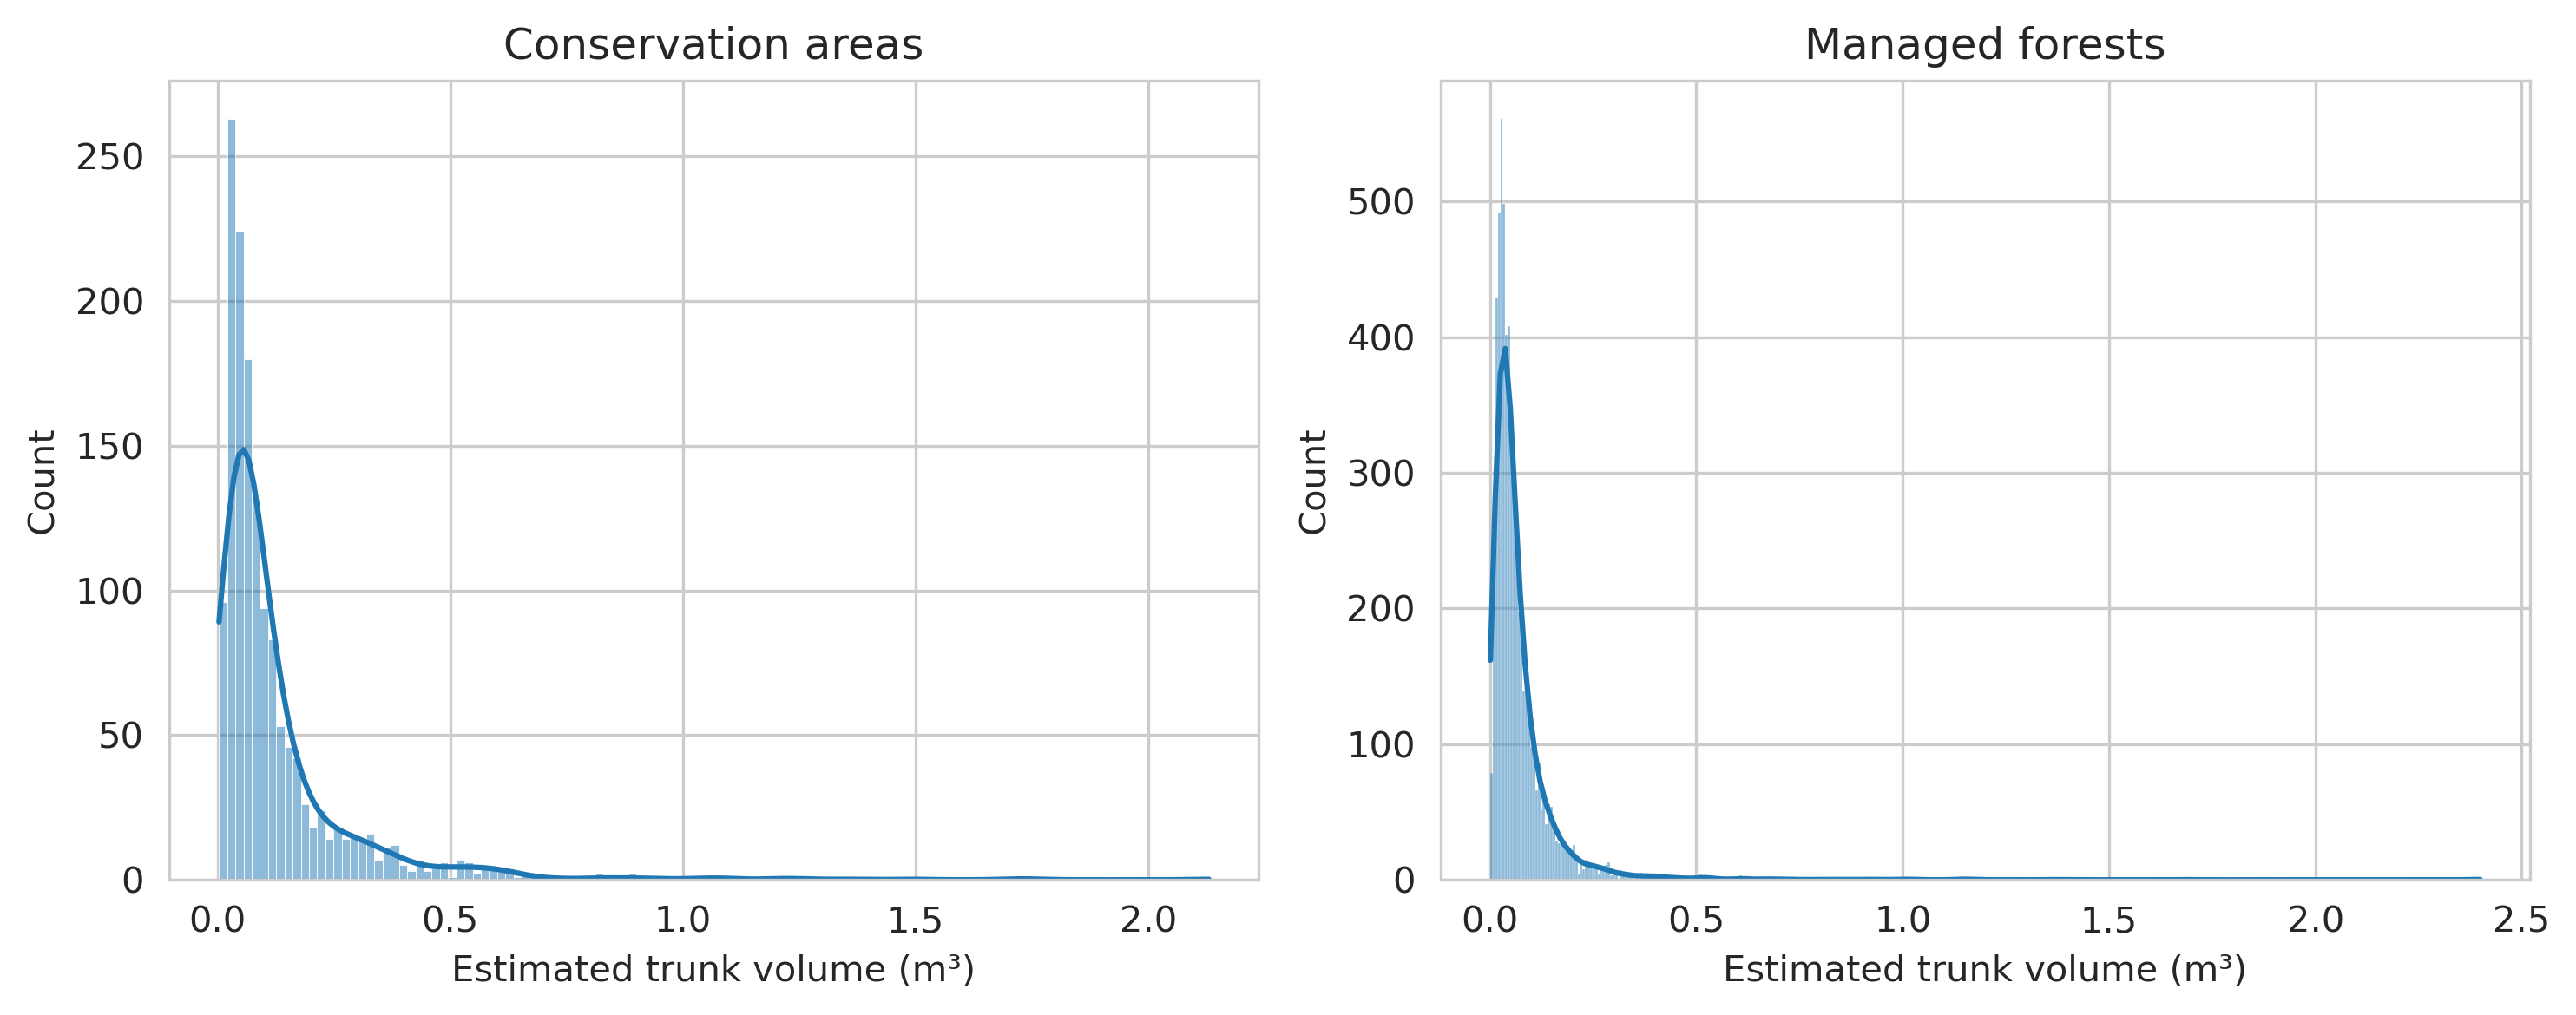

In [ ]:
#| echo: false

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300, sharey=False)
sns.histplot(full_data[(full_data.layer=='groundwood') & (full_data.conservation == 1)], 
             x='v', kde=True, stat='count', ax=ax[0])
ax[0].set_title('Conservation areas')
ax[0].set_xlabel('Estimated trunk volume (m³)')
sns.histplot(full_data[(full_data.layer=='groundwood') & (full_data.conservation == 0)], 
             x='v', kde=True, stat='count', ax=ax[1])
ax[1].set_title('Managed forests')
ax[1].set_xlabel('Estimated trunk volume (m³)')
plt.tight_layout()
plt.savefig('../data/figures/hiidenportti_vdist.jpeg', dpi=300, bbox_inches='tight')

Finally, get estimations of total volume of groundwood m³/ha.

In [ ]:
field_data_path = Path('../data/hiidenportti')
virtual_plot_grid = gpd.read_file(field_data_path/'envelopes_with_trees.geojson')
tot_vplot_area = virtual_plot_grid.area.sum()
cons_areas = gpd.clip(cons_hp, virtual_plot_grid)
tot_cons_area = cons_areas.area.sum()
tot_man_area = tot_vplot_area - tot_cons_area
tot_man_ha = tot_man_area / 10000
tot_cons_ha = tot_cons_area / 10000

est_v_man = full_data[(full_data.layer=='groundwood')&(full_data.conservation==0)].v.sum()/tot_man_ha
est_v_cons = full_data[(full_data.layer=='groundwood')&(full_data.conservation==1)].v.sum()/tot_cons_ha
est_v_tot = full_data[(full_data.layer=='groundwood')].v.sum()/(tot_vplot_area/10000)

print(f'Estimated groundwood volume in managed forests: {est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests: {est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types: {est_v_tot:.2f} ha/m³')

Estimated groundwood volume in managed forests: 10.76 ha/m³
Estimated groundwood volume in conserved forests: 11.59 ha/m³
Estimated groundwood volume in both types: 11.00 ha/m³


### Evo dataset

We constructed the scenes from Evo area as 100x100 meter non-overlapping squares in such way that each virtual plot contained only one circular field plot. This dataset contained 3915 fallen deadwood and 1419 standing deadwood instances, and the total number of deadwood instances in a single field plot varied between 3 and 570, the number of fallen deadwood between 1 and 570, and the number of standing deadwood between 1 and 162. 

In [ ]:
evo_data = gpd.read_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')
cons_evo = conservation_areas[conservation_areas.geometry.intersects(box(*evo_data.total_bounds))]
evo_data['conservation'] = evo_data.progress_apply(lambda row: 1 if row.geometry.intersects(cons_evo.geometry.unary_union)
                                                               else 0, axis=1)
evo_data.to_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')

  0%|          | 0/5334 [00:00<?, ?it/s]

In [ ]:
pd.crosstab(evo_data.conservation, evo_data.label, margins=True)

label,groundwood,uprightwood,All
conservation,,,
0,2369,386,2755
1,1546,1033,2579
All,3915,1419,5334


The total area covered by fallen deadwood was 3117.1m² and the total canopy area for standing deadwood was 7196.4m². On average, a single deadwood instance covered more area compared to Hiidenportti dataset, as the average area for fallen deadwood in Evo was 0.81m² and 5.08m² for standing deadwood. 

In [ ]:
evo_data['area'] = evo_data.geometry.area
evo_data['pixel_area'] = evo_data.area / 0.0485**2
evo_data_dis = evo_data.dissolve(by='label')
evo_data_dis.area

label
groundwood     3117.087445
uprightwood    7196.352919
dtype: float64

In [ ]:
pd.pivot_table(evo_data, index=['conservation', 'label'], values='area', 
               aggfunc=['min', 'max', 'mean', 'median'], margins=True)

min        max      mean    median
                              area       area      area      area
conservation label                                               
0            groundwood   0.064145   8.456464  0.646843  0.489316
             uprightwood  0.364184  41.339628  3.142462  2.017817
1            groundwood   0.092866   8.173691  1.049027  0.735591
             uprightwood  0.319265  35.944833  5.811285  4.102591
All                       0.064145  41.339628  1.944172  0.758211

<seaborn.axisgrid.FacetGrid>

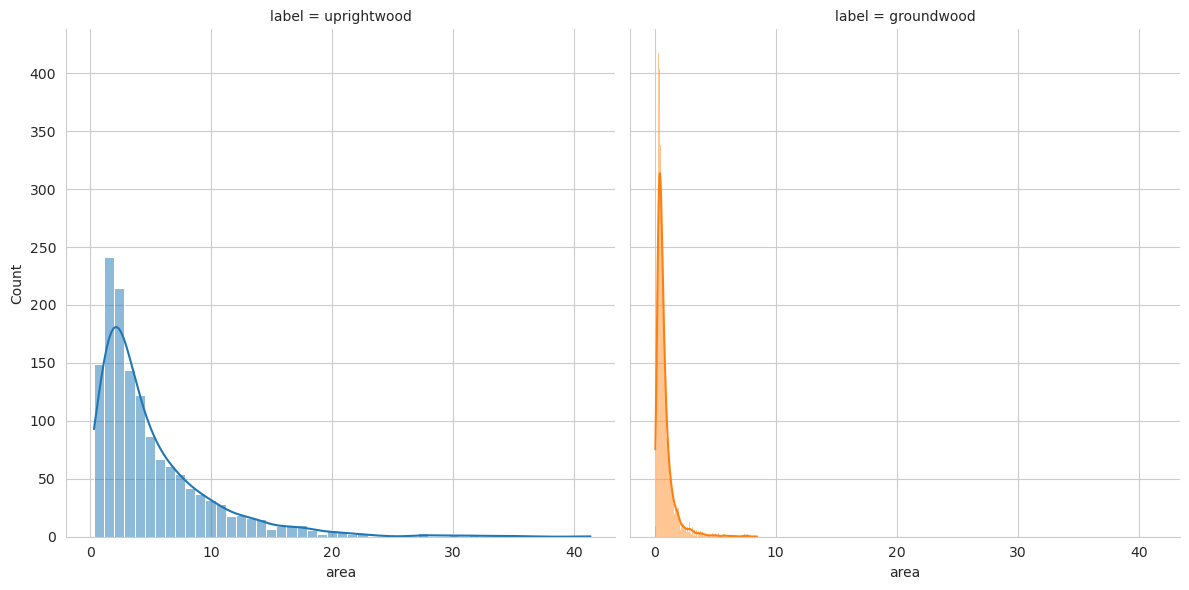

In [ ]:
#| echo: false
g = sns.FacetGrid(evo_data, col='label', height=6, hue='label')
g.map(sns.histplot, 'area', kde=True, stat='count')

Similar observations were found from the average tree length and canopy diameter, as the average trunk length of the fallen trees was around 1 meter more in Evo, and canopy diameter of standing trees was around 60cm larger. However, this is likely due to the vast majority of the annotated trees in Evo dataset being in conserved areas.

In [ ]:
evo_data['tree_length'] = evo_data.apply(lambda row: get_len(row.geometry), axis=1)
pd.pivot_table(evo_data, index=['label'], 
               values=['tree_length'], aggfunc=['min', 'max', 'mean', 'median', 'count'], margins=True)

,min,max,mean,median,count
,tree_length,tree_length,tree_length,tree_length,tree_length
label,,,,,
groundwood,0.575351,24.479043,3.429642,2.790052,3915
uprightwood,0.674329,8.319080,2.958530,2.745163,1419
All,0.575351,24.479043,3.304312,2.779696,5334


In [ ]:
pd.pivot_table(evo_data, index=['conservation','label'], 
               values=['tree_length'], aggfunc=['min', 'max', 'mean', 'median', 'count'], margins=True)

min         max        mean      median  \
                         tree_length tree_length tree_length tree_length   
conservation label                                                         
0            groundwood     0.605847   24.479043    3.113435    2.609120   
             uprightwood    0.674329    8.319080    2.310101    2.080163   
1            groundwood     0.575351   22.625422    3.914179    3.145306   
             uprightwood    0.779996    7.974969    3.200828    2.981814   
All                         0.575351   24.479043    3.304312    2.779696   

                               count  
                         tree_length  
conservation label                    
0            groundwood         2369  
             uprightwood         386  
1            groundwood         1546  
             uprightwood        1033  
All                             5334

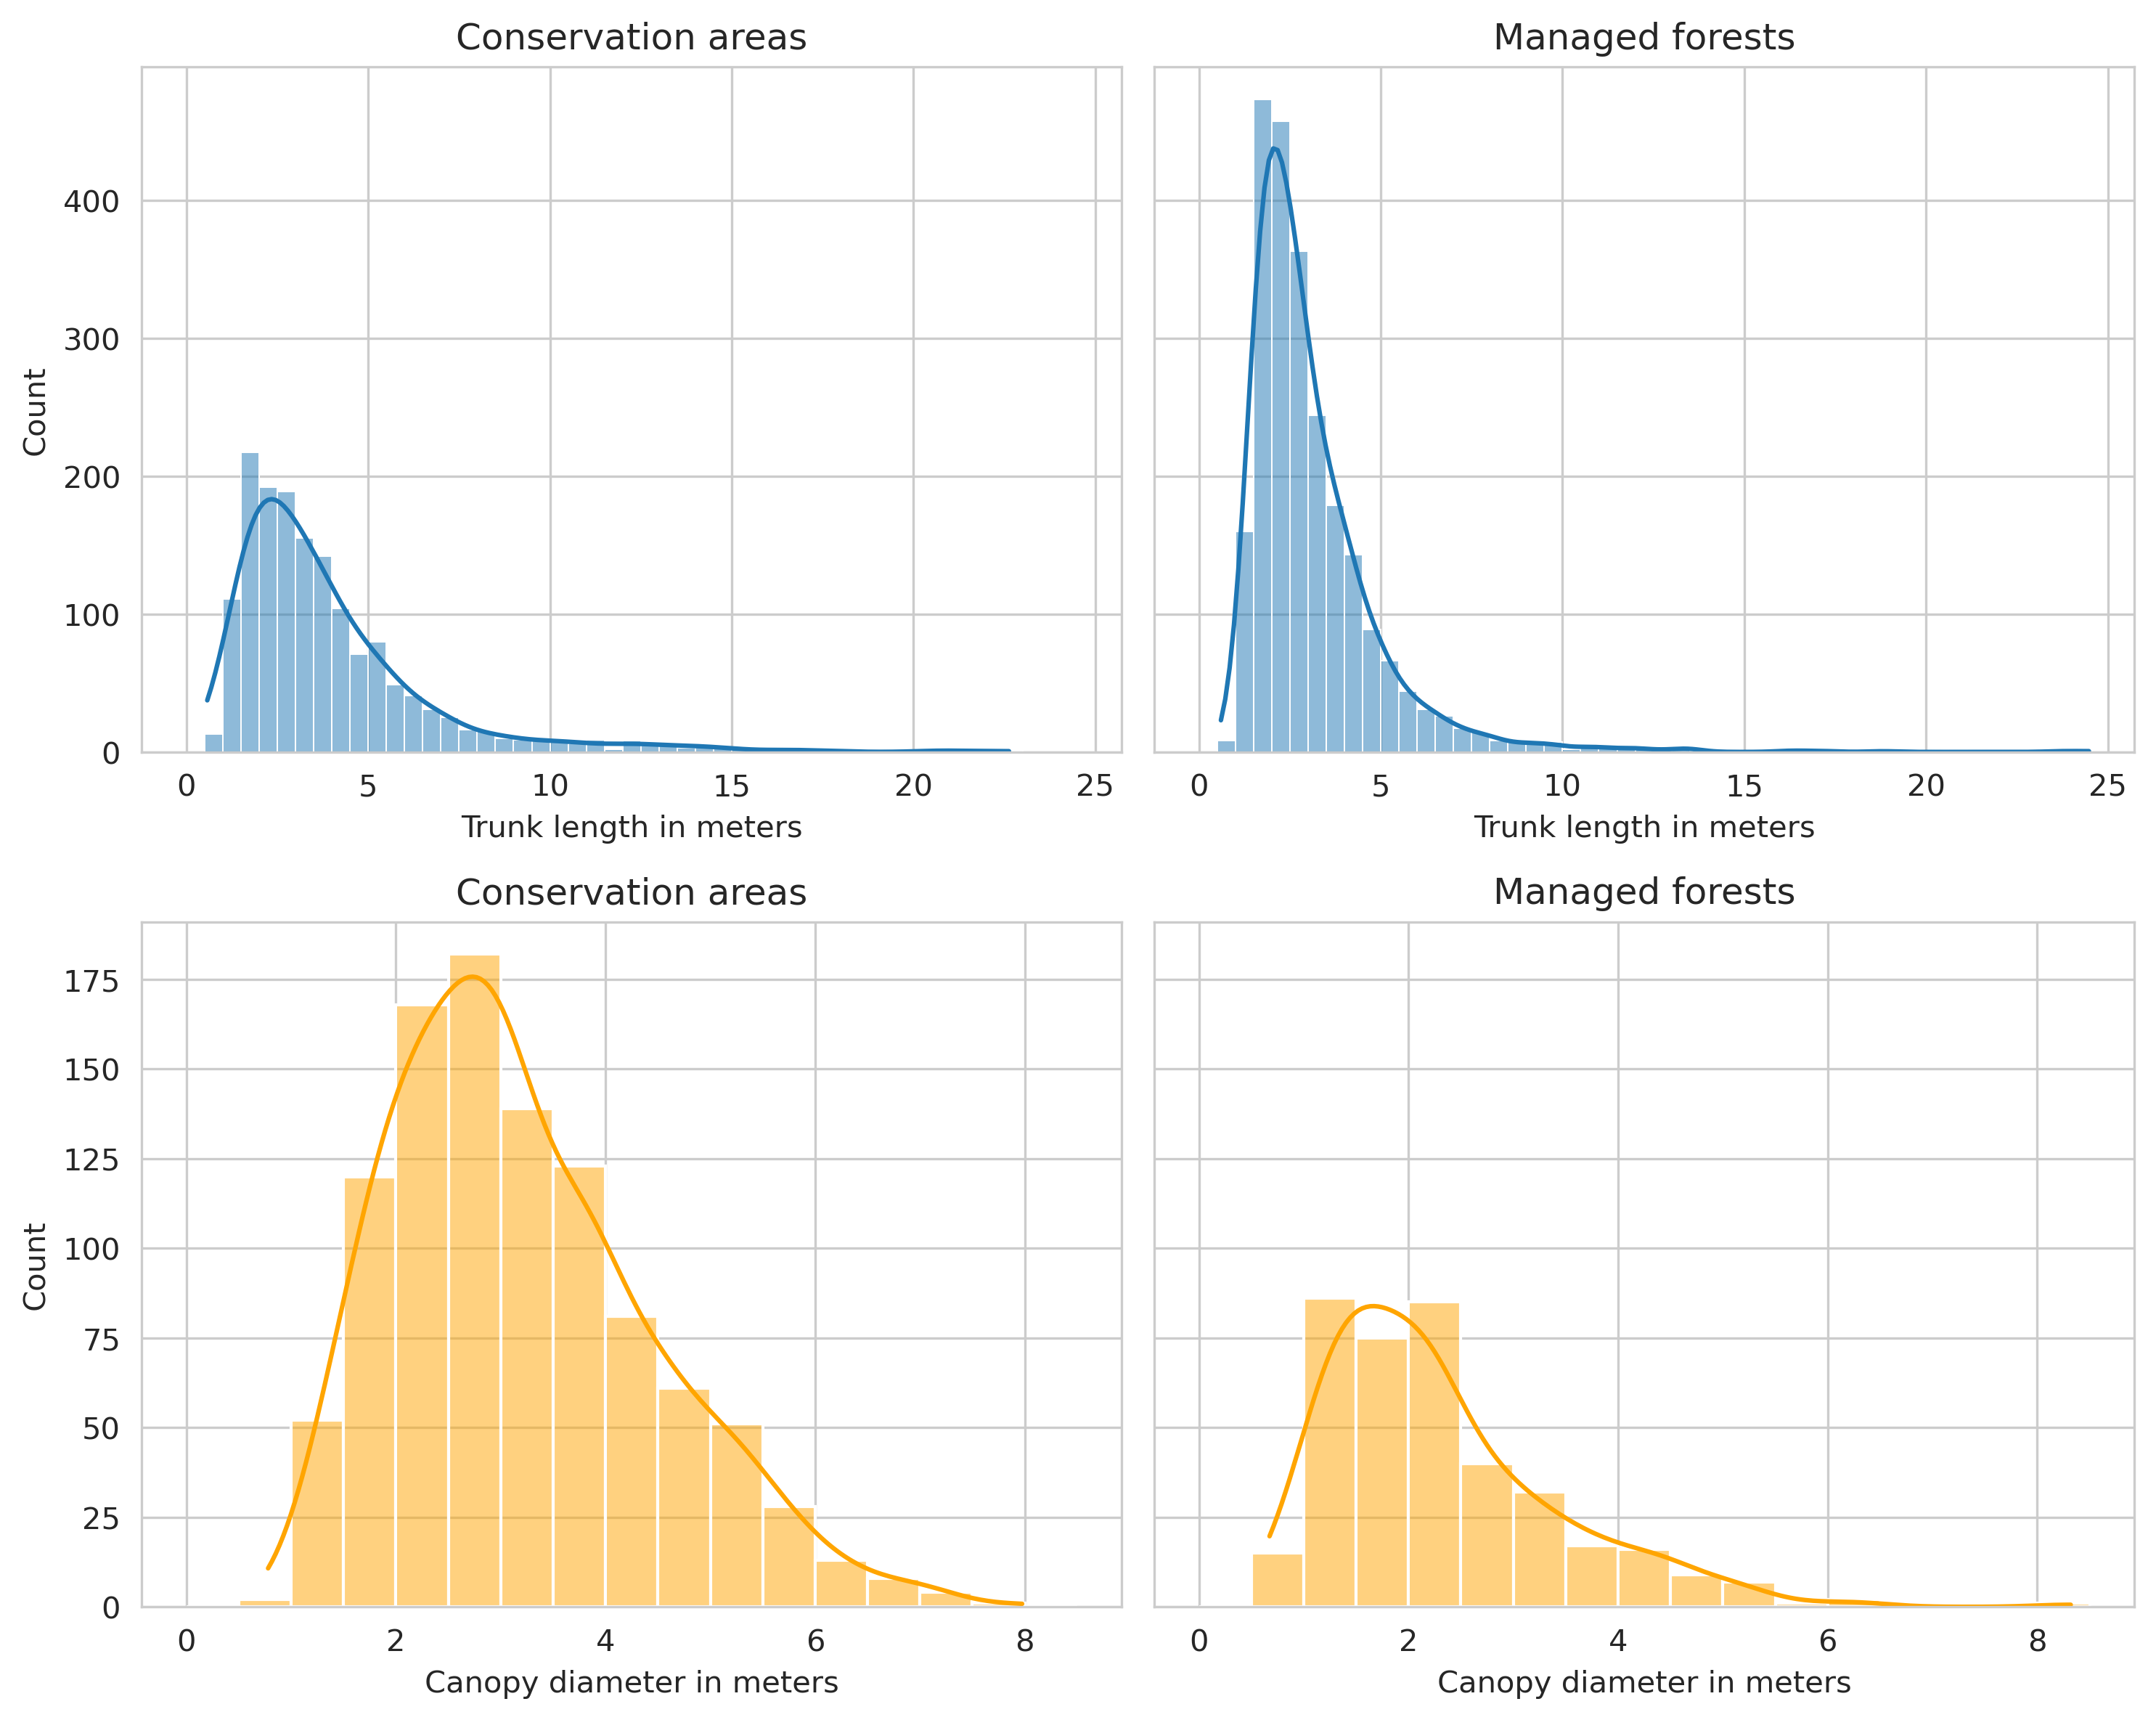

In [ ]:
#| echo: false
fig, ax = plt.subplots(2,2, figsize=(10,8), dpi=300, sharey='row', sharex='row')

sns.histplot(evo_data[(evo_data.label=='groundwood') & (evo_data.conservation == 1)], 
             x='tree_length', kde=True, stat='count', ax=ax[0,0], binwidth=0.5, 
             binrange=(0,evo_data[(evo_data.label=='groundwood')].tree_length.max()))
ax[0,0].set_title('Conservation areas')
ax[0,0].set_xlabel('Trunk length in meters')
sns.histplot(evo_data[(evo_data.label=='groundwood') & (evo_data.conservation == 0)], 
             x='tree_length', kde=True, stat='count', ax=ax[0,1], binwidth=0.5, 
             binrange=(0,evo_data[(evo_data.label=='groundwood')].tree_length.max()))
ax[0,1].set_title('Managed forests')
ax[0,1].set_xlabel('Trunk length in meters')


sns.histplot(evo_data[(evo_data.label=='uprightwood') & (evo_data.conservation == 1)], 
             x='tree_length', kde=True, stat='count', ax=ax[1,0], color='orange', binwidth=0.5, 
             binrange=(0,evo_data[(evo_data.label=='uprightwood')].tree_length.max()))
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Canopy diameter in meters')
sns.histplot(evo_data[(evo_data.label=='uprightwood') & (evo_data.conservation == 0)], 
             x='tree_length', kde=True, stat='count', ax=ax[1,1], color='orange', binwidth=0.5, 
             binrange=(0,evo_data[(evo_data.label=='uprightwood')].tree_length.max()))
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Canopy diameter in meters')
plt.tight_layout()
plt.savefig('../data/figures/evo_lendist.jpeg', dpi=300, bbox_inches='tight')

In addition of annotated fallen trees being longer in Evo than Hiidenportti, they were also thicker, as the average diameter around 20mm more in both forest types, and only 7 annotations had diameter less than 100mm. 

In [ ]:
evo_data['diam'] = evo_data.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
pd.pivot_table(evo_data[evo_data.label=='groundwood'], index=['conservation'], 
               values=['diam'], aggfunc=['min', 'max', 'mean', 'median', 'count'], margins=True)

,min,max,mean,median,count
,diam,diam,diam,diam,diam
conservation,,,,,
0,85.977991,760.781151,200.474161,188.603269,2369
1,101.096058,709.170305,254.250350,233.417789,1546
All,85.977991,760.781151,221.709917,203.275219,3915


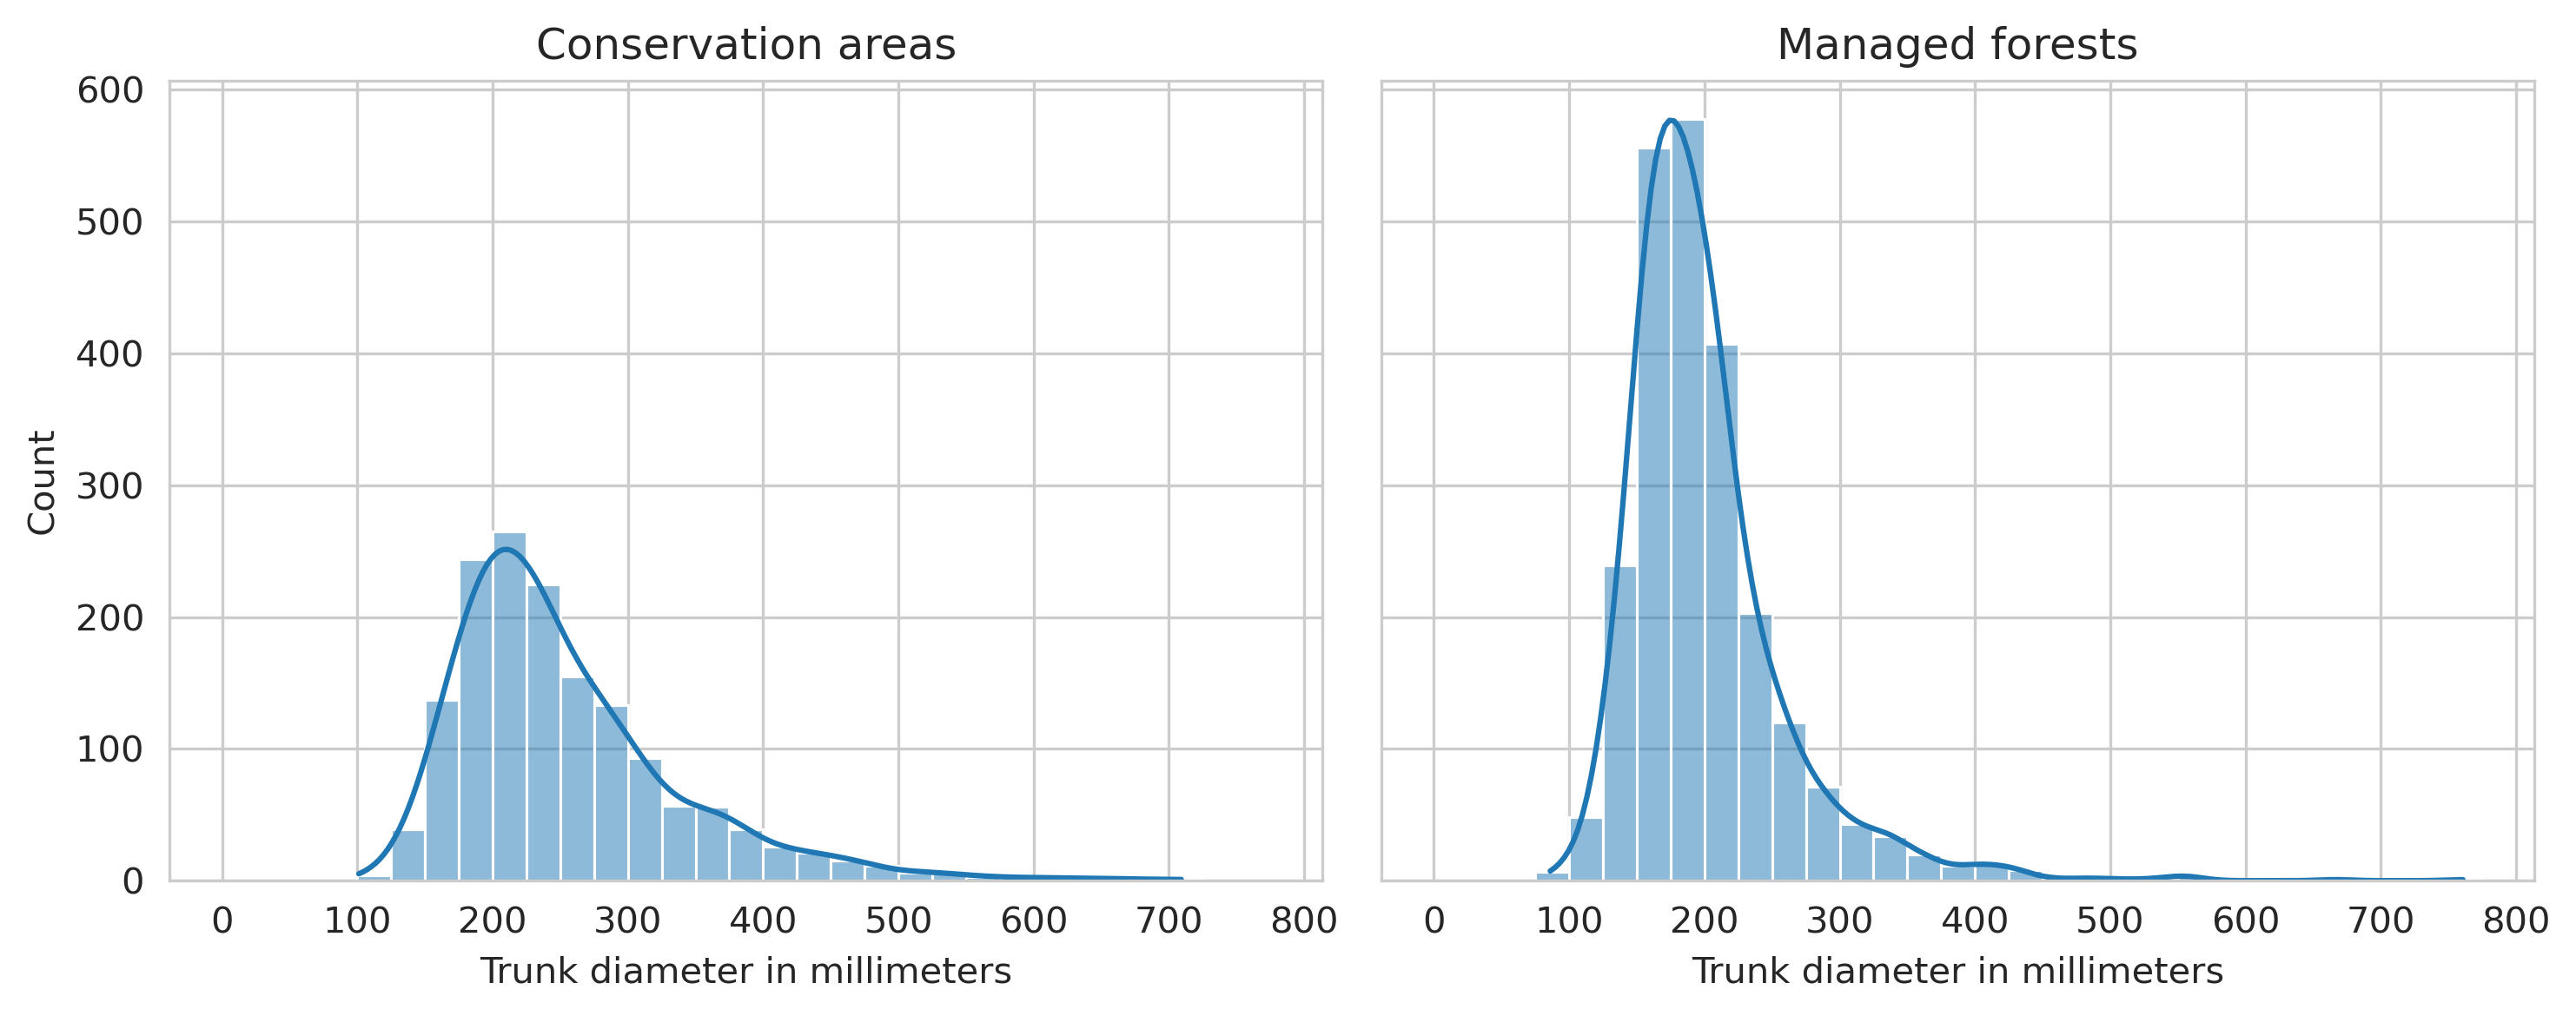

In [ ]:
#| echo: false
fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300, sharey=True, sharex=True)
sns.histplot(evo_data[(evo_data.label=='groundwood') & (evo_data.conservation == 1)], 
             x='diam', kde=True, stat='count', ax=ax[0], binwidth=25, 
             binrange=(0,evo_data[(evo_data.label=='groundwood')].diam.max()))
ax[0].set_title('Conservation areas')
ax[0].set_xlabel('Trunk diameter in millimeters')
sns.histplot(evo_data[(evo_data.label=='groundwood') & (evo_data.conservation == 0)], 
             x='diam', kde=True, stat='count', ax=ax[1], binwidth=25, 
             binrange=(0,evo_data[(evo_data.label=='groundwood')].diam.max()))
ax[1].set_title('Managed forests')
ax[1].set_xlabel('Trunk diameter in millimeters')
plt.tight_layout()
plt.savefig('../data/figures/evo_diamdist.jpeg', dpi=300, bbox_inches='tight')

Look at the largest polygons.


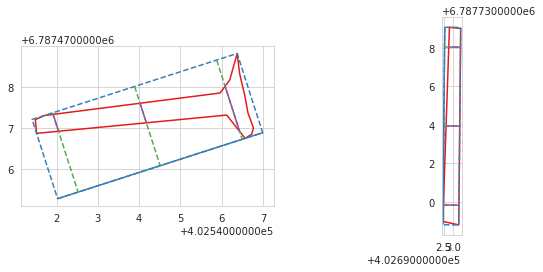

In [ ]:
#| echo: false
fig, axs = plt.subplots(1,2, figsize=(10,4))
for ix, ax in enumerate(axs.flatten()):
    evo_data[(evo_data.label == 'groundwood')&(evo_data.diam>650)].iloc[ix:ix+1].exterior.plot(ax=ax, color="#e41a1c")
    temp = evo_data[(evo_data.label == 'groundwood')&(evo_data.diam>650)].iloc[ix:ix+1].copy()
    geom = temp.iloc[0].geometry
    temp['geometry'] = temp.apply(lambda row: row.geometry.minimum_rotated_rectangle, axis=1)
    temp.exterior.plot(ax=ax, color='#377eb8', linestyle='--')
    temp['geometry'] = temp.apply(lambda row: LineString([(row.geometry.exterior.xy[0][0], row.geometry.exterior.xy[1][0]),
                                                         (row.geometry.exterior.xy[0][1], row.geometry.exterior.xy[1][1])]),
                                  axis=1)
    temp.plot(ax=ax, color='#377eb8')
    temp2 = evo_data[(evo_data.label == 'groundwood')&(evo_data.diam>650)].iloc[ix:ix+1].copy()
    lines = get_three_point_diam_lines(temp2.iloc[0].geometry)
    for l in lines:
        temp2['geometry'] = l
        temp2.plot(ax=ax, edgecolor='#4daf4a', linestyle='--')
    for l in lines:
        temp2['geometry'] = l.intersection(geom)
        temp2.plot(ax=ax, edgecolor='#984ea3')
plt.show()

In [ ]:
evo_data['v'] = evo_data.geometry.apply(cut_cone_volume)
pd.pivot_table(evo_data[evo_data.label=='groundwood'], index=['conservation'], 
               values=['v'], aggfunc=['min', 'max', 'mean', 'median', 'count', 'sum'], margins=True)

,min,max,mean,median,count,sum
,v,v,v,v,v,v
conservation,,,,,,
0,0.004749,2.765285,0.125592,0.076470,2369,297.527245
1,0.011879,4.192773,0.262005,0.141118,1546,405.059473
All,0.004749,4.192773,0.179460,0.092882,3915,702.586718


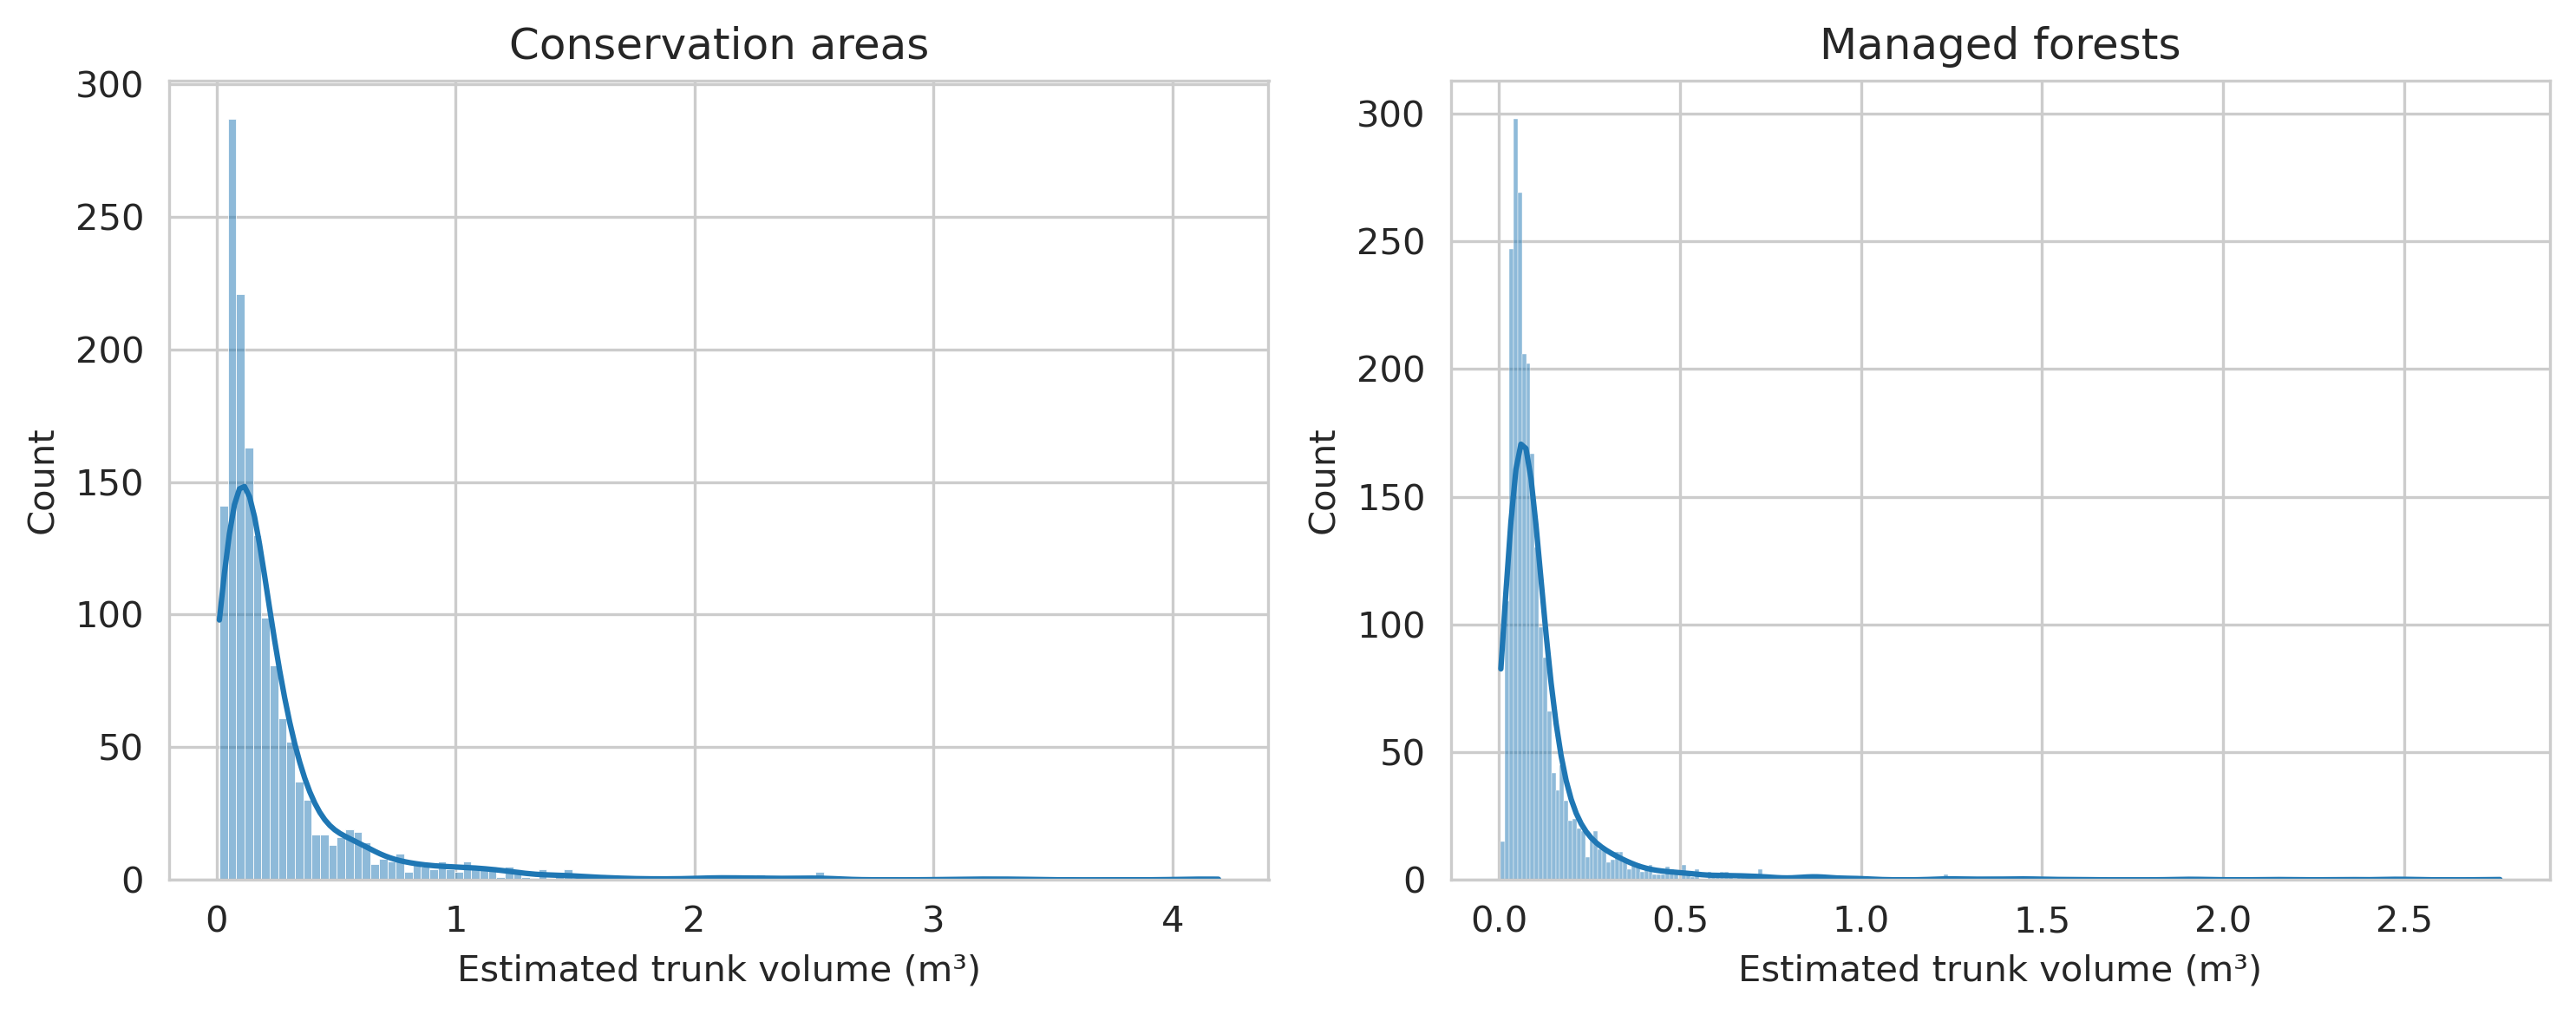

In [ ]:
#|echo: false
fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300, sharey=False)
sns.histplot(evo_data[(evo_data.label=='groundwood') & (evo_data.conservation == 1)], 
             x='v', kde=True, stat='count', ax=ax[0])
ax[0].set_title('Conservation areas')
ax[0].set_xlabel('Estimated trunk volume (m³)')
sns.histplot(evo_data[(evo_data.label=='groundwood') & (evo_data.conservation == 0)], 
             x='v', kde=True, stat='count', ax=ax[1])
ax[1].set_title('Managed forests')
ax[1].set_xlabel('Estimated trunk volume (m³)')
plt.tight_layout()
plt.savefig('../data/figures/evo_vdist.jpeg', bbox_inches='tight', dpi=300)

The estimated total volume of fallen deadwood was 702.59 m^3^, of which 297.52m^3^ was in managed forests and 405.06m^3^ in conservation areas, corresponding to 7.08m^3^/ha of deadwood in managed forests and 13.97 m^3^/ha in conserved forests. 

In [ ]:
evo_fd_path = Path('../data/sudenpesankangas/')
evo_grid = gpd.read_file(evo_fd_path/'vplots.geojson')
evo_grid = evo_grid.to_crs('epsg:3067')
evo_tot_vplot_area = evo_grid.area.sum()
evo_cons_area = cons_evo.overlay(evo_grid).area.sum()
evo_man_area = evo_tot_vplot_area - evo_cons_area
evo_man_ha = evo_man_area / 10000
evo_cons_ha = evo_cons_area / 10000
evo_tot_ha = evo_man_ha + evo_cons_ha

In [ ]:
evo_est_v_man = evo_data[(evo_data.label=='groundwood')&(evo_data.conservation==0)].v.sum()/evo_man_ha
evo_est_v_cons = evo_data[(evo_data.label=='groundwood')&(evo_data.conservation==1)].v.sum()/evo_cons_ha
evo_est_v_tot = evo_data[(evo_data.label=='groundwood')].v.sum()/evo_tot_ha

In [ ]:
print(f'Estimated groundwood volume in managed forests: {evo_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests: {evo_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types: {evo_est_v_tot:.2f} ha/m³')

Estimated groundwood volume in managed forests: 7.08 ha/m³
Estimated groundwood volume in conserved forests: 13.97 ha/m³
Estimated groundwood volume in both types: 9.90 ha/m³


### Training data generation

In order to ensure that no training data leaked into the test set, which would have given our models overly optimistic results, we selected 5 of the virtual plots as the holdout set to test our models. These virtual plots contained both managed and conserved areas, and were only used for testing the models. Furthermore, the remaining 28 plots were spatially split to training and validation sets with 85:15 ratio to ensure that the models were validated during training with data not used for training.

As our virtual plots had too large dimensions to be efficiently used as the training data for the deep learning models, the final preprocessing step for UAV plot images was to split each of them into 512 times 512 pixel image patches. We also split the the polygon data into separate files so that each file only covers this smaller area. Finally, we converted the polygon data into COCO format, in which the polygon coordinates are converted into pixel coordinates related to the corresponding image. Because mosaicking images this way meant that some of the annotated polygons were only partially present in image patches, we removed all partial annotations whose area was less than 25% of the original annotation. Also, all polygons that had bounding box smaller than 16 pixels were discarded, as that small targets can not be accurately found from the data. For test images, as the model outputs were in COCO format, the results were transformed into georeferenced polygon data.

::: {.content-hidden when-format="html"}

#### Hiidenportti train

:::

In [ ]:
tile_folder = Path('../../data/raw/hiidenportti/virtual_plots/train/images/')
vector_folder = Path('../../data/raw/hiidenportti/virtual_plots/train/vectors/')

outpath = Path('../../data/processed/hiidenportti/train_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
import shapely
from shapely.geometry import box
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf.rename(columns={'groundwood':'label'}, inplace=True)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf['label'] = gdf.apply(lambda row: 'Standing' if row.label == 1 else 'Fallen', axis=1)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Train dataset for deadwood detection in Hiidenportti',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('layer')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'hiidenportti_train.json', 'w') as outfile: json.dump(full_coco, outfile)

::: {.content-hidden when-format="html"}

#### Hiidenportti valid

:::

In [ ]:
tile_folder = Path('../../data/raw/hiidenportti/virtual_plots/valid/images/')
vector_folder = Path('../../data/raw/hiidenportti/virtual_plots/valid/vectors/')

outpath = Path('../../data/processed/hiidenportti/valid_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf.rename(columns={'groundwood':'label'}, inplace=True)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf['label'] = gdf.apply(lambda row: 'Standing' if row.label == 1 else 'Fallen', axis=1)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Validation dataset for deadwood detection in Hiidenportti',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('layer')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'hiidenportti_valid.json', 'w') as outfile: json.dump(full_coco, outfile)

::: {.content-hidden when-format="html"}

#### Hiidenportti test

:::

In [ ]:
tile_folder = Path('../../data/raw/hiidenportti/virtual_plots/test/images/')
vector_folder = Path('../../data/raw/hiidenportti/virtual_plots/test/vectors/')

outpath = Path('../../data/processed/hiidenportti/test_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf.rename(columns={'groundwood':'label'}, inplace=True)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf['label'] = gdf.apply(lambda row: 'Standing' if row.label == 1 else 'Fallen', axis=1)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Test dataset for deadwood detection in Hiidenportti',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('layer')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'hiidenportti_test.json', 'w') as outfile: json.dump(full_coco, outfile)

::: {.content-hidden when-format="html"}

#### Sudenpesänkangas train

:::

In [ ]:
tile_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/train/images/')
vector_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/train/vectors/')

outpath = Path('../../data/processed/sudenpesankangas/train_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

In [ ]:
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Train dataset for deadwood detection in Sudenpesänkangas',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('label')

In [ ]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'sudenpesankangas_train.json', 'w') as outfile: json.dump(full_coco, outfile)

::: {.content-hidden when-format="html"}

#### Sudenpesänkangas valid

:::

In [ ]:
tile_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/valid/images/')
vector_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/valid/vectors/')

outpath = Path('../../data/processed/sudenpesankangas/valid_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

In [ ]:
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Train dataset for deadwood detection in Sudenpesänkangas',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('label')

In [ ]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'sudenpesankangas_valid.json', 'w') as outfile: json.dump(full_coco, outfile)

::: {.content-hidden when-format="html"}

#### Sudenpesänkangas test

:::

In [ ]:
tile_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/test/images/')
vector_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/test/vectors/')

outpath = Path('../../data/processed/sudenpesankangas/test_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

In [ ]:
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Test dataset for deadwood detection in Sudenpesänkangas',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('label')

In [ ]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'sudenpesankangas_test.json', 'w') as outfile: json.dump(full_coco, outfile)